In [3]:
"""
Estimasi Tax Gap Provinsi Indonesia
Latent Variable Framework dengan Machine Learning
Author: Hardana Gading Perdana Putra, Fachri Husein Harahap, Dwi Juli Yantono

Data Sources:
- GADM: https://gadm.org/download_country.html
- Google Earth Engine: https://console.cloud.google.com/earth-engine
- BPS PDRB: https://www.bps.go.id/id/statistics-table/2/NTM0IzI=/-seri-2010-1pdrbatasdasarhargaberlaku-menurut-pengeluaran.html
- BPS IPM: https://www.bps.go.id/id/statistics-table/3/V25GaFNHaExaMnhITm1sWmRrUlJZelJzYUc1SGR6MDkjMw==/indeks-pembangunan-manusia-menurut-provinsi--2023.html?year=2023
- BPS Penduduk: https://sulut.bps.go.id/id/statistics-table/2/OTU4IzI=/jumlah-penduduk-menurut-provinsi-di-indonesia.html
- BPS Informal: https://www.bps.go.id/id/statistics-table/2/MjE1MyMy/proporsi-lapangan-kerja-informal-menurut-provinsi.html
- DJPK: https://djpk.kemenkeu.go.id/portal/data/apbd
"""

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.optimize import minimize
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr
from sklearn.utils import resample
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 10

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================

def clean_numeric_column(series, decimal_sep=','):
    """Clean numeric columns with European notation"""
    if series.dtype == 'object':
        cleaned = series.astype(str).str.replace('.', '', regex=False)
        cleaned = cleaned.str.replace(',', '.', regex=False)
        return pd.to_numeric(cleaned, errors='coerce')
    return series

def moment_conditions(params, Y1, Y2, X_under, Z, return_moments=False):
    """GMM moment conditions function."""
    N = len(Y1)
    theta = np.array(params[:N], dtype=np.float64)
    beta = np.array(params[N:], dtype=np.float64)
    delta_logit = X_under @ beta
    delta = expit(delta_logit)  # Logistic for delta in [0, 1]

    m1 = Y1 - theta * (1 - delta)  # Official measurement equation
    m2 = Y2 - theta  # Geospatial measurement equation
    m3 = (m1.reshape(-1, 1) * Z).flatten()  # Orthogonality conditions

    moments = np.concatenate([m1, m2, m3])
    if return_moments:
        return moments
    return np.sum(moments**2)  # GMM objective

def estimate_stage2_gmm(Y1, Y2, X_under, Z):
    """FIXED GMM estimation with correct signs and better convergence."""
    print("\n--- Starting Stage 2: GMM Estimation ---")
    N = len(Y1)

    # Initial values - start with reasonable estimates
    theta_init = (Y1 + Y2) / 2  # Average of two measurements
    # CORRECTED: Start with small positive values for informal/agriculture
    beta_init = np.array([-1.5, 0.03, 0.02, -0.01])
    params_init = np.concatenate([theta_init, beta_init])

    # CORRECTED BOUNDS: Allow positive coefficients for informal and agriculture
    # Based on theory: higher informality → higher underreporting
    theta_bounds = [(Y1[i] * 0.9, Y1[i] * 2.5) for i in range(N)]
    beta_bounds = [
        (-5, 1),       # Intercept: can be negative
        (0, 0.1),      # % Informal: MUST be positive (higher informal = higher underreporting)
        (0, 0.1),      # % Pertanian: MUST be positive
        (-0.1, 0.1)    # IPM: can be slightly negative or positive
    ]
    bounds = theta_bounds + beta_bounds

    print(f"Data check - Y1 range: [{Y1.min():.2f}, {Y1.max():.2f}]")
    print(f"Data check - Y2 range: [{Y2.min():.2f}, {Y2.max():.2f}]")
    print("Optimizing GMM objective function...")

    result = minimize(
        moment_conditions,
        params_init,
        args=(Y1, Y2, X_under, Z),
        method='L-BFGS-B',
        bounds=bounds,
        options={'maxiter': 5000, 'ftol': 1e-10, 'gtol': 1e-9}
    )

    if not result.success:
        print(f"⚠️ Warning: Stage 2 optimization did not fully converge.")
        print(f"   Message: {result.message}")
    else:
        print("✓ Stage 2 optimization converged successfully!")

    # Extract estimates
    theta_hat = result.x[:N]
    beta_hat = result.x[N:]
    delta_hat = expit(X_under @ beta_hat)

    print("\n=== Stage 2 Estimated Beta Coefficients (Underreporting Model) ===")
    param_names = ['Intercept (β₀)', '% Informal (β₁)', '% Pertanian (β₂)', 'IPM (β₃)']
    for name, val in zip(param_names, beta_hat):
        print(f"  {name:20s}: {val:8.4f}")

    print(f"\n=== Diagnostics ===")
    print(f"Final objective value: {result.fun:.6f}")
    print(f"Mean underreporting rate: {delta_hat.mean():.4f} ({delta_hat.mean()*100:.2f}%)")
    print(f"Underreporting rate range: [{delta_hat.min():.4f}, {delta_hat.max():.4f}]")
    print(f"Mean True PDRB / Official PDRB: {(theta_hat/Y1).mean():.4f}")

    print("--- Stage 2 Complete ---")
    return theta_hat, delta_hat, beta_hat, result.success

def bootstrap_iteration(df_boot, features, X_under_cols, Z_cols, model, scaler, beta_init):
    """Single bootstrap iteration"""
    try:
        X_scaled = scaler.transform(df_boot[features].values)
        Y2_boot = model.predict(X_scaled)
        Y1_boot = df_boot['PDRB_resmi'].values.astype(np.float64)
        X_under_boot = df_boot[X_under_cols].values.astype(np.float64)
        Z_boot = df_boot[Z_cols].values.astype(np.float64)

        beta_init_perturbed = beta_init + np.random.normal(0, 0.01, size=len(beta_init))
        theta_init = (Y1_boot + Y2_boot) / 2
        params_init = np.concatenate([theta_init, beta_init_perturbed])

        N = len(Y1_boot)
        theta_bounds = [(Y1_boot[i]*0.9, Y1_boot[i]*2.5) for i in range(N)]
        beta_bounds = [(-5, 1), (0, 0.1), (0, 0.1), (-0.1, 0.1)]
        bounds = theta_bounds + beta_bounds

        result = minimize(
            moment_conditions, params_init,
            args=(Y1_boot, Y2_boot, X_under_boot, Z_boot),
            method='L-BFGS-B', bounds=bounds,
            options={'maxiter': 5000, 'ftol': 1e-10}
        )

        if result.success:
            return {
                'theta': result.x[:N],
                'delta': expit(X_under_boot @ result.x[N:]),
                'beta': result.x[N:]
            }
    except:
        pass
    return None

In [4]:
# ============================================================================
# MAIN ANALYSIS
# ============================================================================

if __name__ == "__main__":
    INPUT_CSV = 'data.csv'
    TRAIN_YEARS = [2019, 2020, 2021]
    VAL_YEARS = [2022]
    TEST_YEARS = [2023]
    N_BOOTSTRAP = 500

    print("="*70)
    print("TAX GAP ESTIMATION - INDONESIA PROVINCES")
    print("="*70)

    # ========================================================================
    # 1. DATA LOADING & PREPROCESSING
    # ========================================================================

    print("\n[1/8] Loading Data...")

    df = pd.read_csv(INPUT_CSV, delimiter=';', decimal=',')

    # Rename columns
    df.rename(columns={
        'PDRB': 'PDRB_resmi',
        'Konsumsi_RT': 'konsumsi_perkapita',
        'NTL': 'NTL_mean',
        'NO2': 'NO2_median',
        'Proporsi_Informal': 'pct_informal',
        'Realisasi_Pajak': 'tax_realization',
        'Proporsi_Agrikultur': 'pct_pertanian',
        'Jumlah_Penduduk': 'jumlah_penduduk',
        'IPM': 'IPM',
        'Tahun': 'year',
        'Provinsi': 'province_name',
        'ID_Provinsi': 'province_id'
    }, inplace=True)

    # Clean numeric columns
    numeric_cols = ['PDRB_resmi', 'konsumsi_perkapita', 'NTL_mean', 'NO2_median',
                   'pct_informal', 'tax_realization', 'jumlah_penduduk', 'IPM', 'pct_pertanian']

    for col in numeric_cols:
        if col in df.columns:
            df[col] = clean_numeric_column(df[col])

    # Remove missing values
    critical_cols = ['PDRB_resmi', 'NTL_mean', 'NO2_median', 'pct_informal',
                    'konsumsi_perkapita', 'IPM', 'jumlah_penduduk', 'tax_realization']
    df.dropna(subset=critical_cols, inplace=True)

    # VERIFY UNITS
    print(f"\n  ✓ UNIT VERIFICATION:")
    print(f"    PDRB range: {df['PDRB_resmi'].min():.2f} - {df['PDRB_resmi'].max():.2f} Billion Rp")
    print(f"    Smallest: {df[df['PDRB_resmi'] == df['PDRB_resmi'].min()]['province_name'].values[0]}")
    print(f"    Largest: {df[df['PDRB_resmi'] == df['PDRB_resmi'].max()]['province_name'].values[0]}")
    print(f"  ✓ Observations: {len(df)}, Provinces: {df['province_id'].nunique()}")
    print(f"  ✓ Years: {sorted(df['year'].unique())}")

    # Log transformations
    df['ln_NTL'] = np.log(df['NTL_mean'].clip(lower=1e-10))
    df['ln_NO2'] = np.log(df['NO2_median'].clip(lower=1e-20))
    df['ln_konsumsi'] = np.log(df['konsumsi_perkapita'].clip(lower=1))
    df['ln_penduduk'] = np.log(df['jumlah_penduduk'].clip(lower=1))
    df['const'] = 1



TAX GAP ESTIMATION - INDONESIA PROVINCES

[1/8] Loading Data...

  ✓ UNIT VERIFICATION:
    PDRB range: 39695.50 - 3443030.00 Billion Rp
    Smallest: Maluku Utara
    Largest: DKI Jakarta
  ✓ Observations: 170, Provinces: 34
  ✓ Years: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [5]:
    # ========================================================================
    # 2. DESCRIPTIVE STATISTICS
    # ========================================================================

    print("\n[2/8] Descriptive Statistics...")

    desc_vars = ['PDRB_resmi', 'NTL_mean', 'NO2_median', 'pct_informal',
                 'konsumsi_perkapita', 'IPM', 'jumlah_penduduk']
    desc_stats = df[desc_vars].describe().T

    # Create proper Table 4.1
    table_41 = desc_stats[['mean', 'std', '50%', 'min', 'max']].copy()
    table_41.columns = ['Mean', 'Std Dev', 'Median', 'Min', 'Max']
    table_41.index = ['PDRB Resmi (Miliar Rp)', 'NTL Intensity (nW/cm²/sr)',
                      'NO₂ Density (mol/m²)', '% Pekerja Informal',
                      'Konsumsi RT (Rp/kapita)', 'IPM', 'Jumlah Penduduk']

    print("\n=== Table 4.1: Descriptive Statistics (2019-2023, N={}) ===".format(len(df)))
    print(table_41.round(2))
    table_41.to_csv('table_4_1_descriptive.csv')

    # Correlation matrix
    corr_vars = ['PDRB_resmi', 'NTL_mean', 'NO2_median', 'pct_informal', 'konsumsi_perkapita']
    corr_matrix = df[corr_vars].corr()

    print("\n=== Table 4.2: Correlation Matrix ===")
    print(corr_matrix.round(3))
    corr_matrix.to_csv('table_4_2_correlation.csv')

    # Enhanced correlation heatmap
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.3f', cmap='RdBu_r',
                center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix (Pearson)', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig('figure_4_1_correlation.png', dpi=300, bbox_inches='tight')
    plt.close()




[2/8] Descriptive Statistics...

=== Table 4.1: Descriptive Statistics (2019-2023, N=170) ===
                                 Mean      Std Dev      Median         Min  \
PDRB Resmi (Miliar Rp)      535432.04    756267.75   218697.00    39695.50   
NTL Intensity (nW/cm²/sr)    95941.42     78356.66    71803.85    11018.17   
NO₂ Density (mol/m²)             0.02         0.02        0.01        0.00   
% Pekerja Informal              59.42        10.20       60.42       29.57   
Konsumsi RT (Rp/kapita)    2691988.46   2246899.18  2195476.42  1106361.98   
IPM                             72.55         3.89       72.68       60.84   
Jumlah Penduduk            7986828.82  11280324.94  4244850.00   695600.00   

                                   Max  
PDRB Resmi (Miliar Rp)      3443030.00  
NTL Intensity (nW/cm²/sr)    401884.91  
NO₂ Density (mol/m²)              0.06  
% Pekerja Informal               84.43  
Konsumsi RT (Rp/kapita)    16759946.74  
IPM                              8

In [6]:
    # ========================================================================
    # 3. STAGE 1: XGBOOST MODEL
    # ========================================================================

    print("\n[3/8] Stage 1: XGBoost Training...")

    features = ['ln_NTL', 'ln_NO2', 'pct_informal', 'ln_konsumsi',
                'IPM', 'ln_penduduk', 'pct_pertanian']

    # Adaptive weighted target
    elasticity = 1.3
    nat_stats = df.groupby('year')[['PDRB_resmi', 'NTL_mean']].sum()
    alpha = np.log(nat_stats['PDRB_resmi'].mean()) - elasticity * np.log(nat_stats['NTL_mean'].mean())

    df['PDRB_lights'] = np.exp(alpha + elasticity * df['ln_NTL'])
    df['w_official'] = 1 / (1 + df['pct_informal'] / 50)
    df['Y_target'] = df['w_official'] * df['PDRB_resmi'] + (1 - df['w_official']) * df['PDRB_lights']

    # Split data
    train_mask = df['year'].isin(TRAIN_YEARS)
    val_mask = df['year'].isin(VAL_YEARS)
    test_mask = df['year'].isin(TEST_YEARS)

    X_train, y_train = df.loc[train_mask, features], df.loc[train_mask, 'Y_target']
    X_val, y_val = df.loc[val_mask, features], df.loc[val_mask, 'Y_target']
    X_test, y_test = df.loc[test_mask, features], df.loc[test_mask, 'Y_target']

    # Standardize
    scaler = StandardScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(X_test)
    X_all_sc = scaler.transform(df[features])

    # Train XGBoost
    seeds = [1, 2, 3, 4, 5, 6, 99, 8, 80, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20] # You may expand this list for more seeds
    ypred_list, ytest_list = [], []

    for seed in seeds:
        model = xgb.XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5,
            min_child_weight=3, subsample=0.8, colsample_bytree=0.8,
            gamma=0.1, random_state=seed, verbosity=0,
            reg_alpha=1, reg_lambda=2
        )
        model.fit(X_train_sc, y_train, eval_set=[(X_val_sc, y_val)], verbose=False)
        ypred = model.predict(X_test_sc)
        ypred_list.append(ypred)
        ytest_list.append(y_test.values.copy()) # ensures consistent ordering

    # Aggregate test predictions
    ytest = ytest_list[0]
    ypred_mean = np.mean(ypred_list, axis=0)
    ypred_std = np.std(ypred_list, axis=0)

    r2 = r2_score(ytest, ypred_mean)
    rmse = np.sqrt(mean_squared_error(ytest, ypred_mean))
    mae = mean_absolute_error(ytest, ypred_mean)
    mape = mean_absolute_percentage_error(ytest, ypred_mean) * 100
    print(f"Test R² (mean ensemble): {r2:.3f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    print(f"Prediction std (ensemble): {np.mean(ypred_std):.2f}")

    print("\n=== Table 4.3: Model Performance (Test Set 2023, N=34) ===")
    perf = pd.DataFrame({
        'Metric': ['R²', 'RMSE (Billion Rp)', 'MAE (Billion Rp)', 'MAPE (%)'],
        'Value': [r2, rmse, mae, mape]
    })
    print(perf.to_string(index=False))
    perf.to_csv('table_4_3_performance.csv', index=False)

    # SHAP analysis
    print("\n  Calculating SHAP values...")
    explainer = shap.Explainer(model.predict, X_train_sc)
    shap_values = explainer(X_test_sc)
    shap_imp = np.abs(shap_values.values).mean(axis=0)

    importance_df = pd.DataFrame({
        'Feature': features,
        'Mean |SHAP|': shap_imp,
        '% Contribution': (shap_imp / shap_imp.sum()) * 100
    }).sort_values('Mean |SHAP|', ascending=False).reset_index(drop=True)

    # Rename features for display
    importance_df['Feature'] = importance_df['Feature'].replace({
        'ln_NTL': 'ln_NTL', 'ln_NO2': 'ln_NO₂', 'pct_informal': '% Informal',
        'ln_konsumsi': 'ln_Konsumsi', 'IPM': 'IPM', 'ln_penduduk': 'ln_Penduduk',
        'pct_pertanian': '% Pertanian'
    })

    print("\n=== Table 4.4: Feature Importance (Mean |SHAP|) ===")
    print(importance_df.round(3))
    importance_df.to_csv('table_4_4_importance.csv', index=False)

    # SHAP summary plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values.values, X_test_sc, feature_names=features, show=False)
    plt.title('SHAP Summary Plot', fontsize=14, weight='bold')
    plt.tight_layout()
    plt.savefig('figure_4_2_shap.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Actual vs Predicted plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test, ypred_mean, alpha=0.6, s=100, edgecolors='black', linewidth=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual PDRB (Billion Rp)', fontsize=12)
    plt.ylabel('Predicted PDRB (Billion Rp)', fontsize=12)
    plt.title(f'Actual vs Predicted (R²={r2:.4f}, MAPE={mape:.2f}%)',
              fontsize=14, weight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('figure_4_3_actual_vs_pred.png', dpi=300, bbox_inches='tight')
    plt.close()

    # Generate Y2 for all data
    df['Y2_geospatial'] = model.predict(X_all_sc)




[3/8] Stage 1: XGBoost Training...
Test R² (mean ensemble): 0.828, RMSE: 230380.57, MAE: 107406.69
Prediction std (ensemble): 19462.87

=== Table 4.3: Model Performance (Test Set 2023, N=34) ===
           Metric         Value
               R²      0.828180
RMSE (Billion Rp) 230380.567805
 MAE (Billion Rp) 107406.690911
         MAPE (%)     20.202474

  Calculating SHAP values...

=== Table 4.4: Feature Importance (Mean |SHAP|) ===
       Feature  Mean |SHAP|  % Contribution
0  ln_Penduduk   152198.992          37.571
1       ln_NTL   115933.197          28.619
2  ln_Konsumsi    85585.488          21.127
3          IPM    18467.135           4.559
4  % Pertanian    13980.210           3.451
5   % Informal    11478.498           2.834
6       ln_NO₂     7452.703           1.840


In [7]:
    # ========================================================================
    # 4. STAGE 2: GMM ESTIMATION (CORRECTED)
    # ========================================================================

    print("\n[4/8] Stage 2: GMM Estimation...")

    Y1 = df['PDRB_resmi'].values.astype(np.float64)
    Y2 = df['Y2_geospatial'].values.astype(np.float64)

    X_under_cols = ['const', 'pct_informal', 'pct_pertanian', 'IPM']
    Z_cols = ['const', 'pct_informal', 'pct_pertanian', 'IPM', 'ln_penduduk']

    X_under = df[X_under_cols].values.astype(np.float64)
    Z = df[Z_cols].values.astype(np.float64)

    theta_hat, delta_hat, beta_hat, success = estimate_stage2_gmm(Y1, Y2, X_under, Z)

    df['true_PDRB'] = theta_hat
    df['underreporting_rate'] = delta_hat
    df['shadow_economy'] = theta_hat - Y1
    df['pct_shadow'] = (df['shadow_economy'] / Y1) * 100




[4/8] Stage 2: GMM Estimation...

--- Starting Stage 2: GMM Estimation ---
Data check - Y1 range: [39695.50, 3443030.00]
Data check - Y2 range: [28142.29, 1773996.38]
Optimizing GMM objective function...
⚠️ Warning: Stage 2 optimization did not fully converge.
   Message: STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

=== Stage 2 Estimated Beta Coefficients (Underreporting Model) ===
  Intercept (β₀)      :  -4.7740
  % Informal (β₁)     :   0.0098
  % Pertanian (β₂)    :   0.0207
  IPM (β₃)            :   0.0164

=== Diagnostics ===
Final objective value: 274422999411203.812500
Mean underreporting rate: 0.0700 (7.00%)
Underreporting rate range: [0.0397, 0.1223]
Mean True PDRB / Official PDRB: 1.0744
--- Stage 2 Complete ---


In [8]:
# Robustness: Leave-One-Out Province (Jackknife)
provinces = df['province_id'].unique()
loo_results = []
for prov in provinces:
    df_loo = df[df['province_id'] != prov].copy()
    # Run pipeline or at least recalculate aggregate indicator, e.g.:
    nat_shadow_pct = df_loo['shadow_economy'].sum() / df_loo['PDRB_resmi'].sum() * 100
    loo_results.append({'province': prov, 'national_shadow_pct': nat_shadow_pct})
jackknife_df = pd.DataFrame(loo_results)
print(jackknife_df.sort_values('national_shadow_pct'))

# Robustness: Leave-One-Feature-Out (if feasible with your pipeline)
features = ['ln_NTL', 'ln_NO2', 'ln_konsumsi', 'IPM', 'ln_penduduk', 'pct_informal', 'pct_pertanian']
robust_feat_results = []
for f in features:
    subset = [x for x in features if x != f]
    # E.g. retrain stage 1 here with subset if your pipeline modular, otherwise skip
    # This requires refactoring if model training isn't in a function

    province  national_shadow_pct
23        24             6.511790
13        14             6.582580
25        26             6.694926
24        25             6.697146
18        19             6.709605
27        28             6.721477
33        34             6.722366
7          8             6.731272
31        32             6.740595
11        12             6.744183
2          3             6.744841
0          1             6.749326
21        22             6.749859
5          6             6.751187
29        30             6.754822
28        29             6.754856
19        20             6.755284
30        31             6.755817
1          2             6.761627
32        33             6.766767
22        23             6.769131
12        13             6.770971
20        21             6.771745
15        16             6.775004
6          7             6.778358
26        27             6.786092
3          4             6.789420
9         10             6.789926
16        17  

In [9]:
    # ========================================================================
    # 5. BOOTSTRAP FOR CONFIDENCE INTERVALS
    # ========================================================================

    print(f"\n[5/8] Bootstrap (N={N_BOOTSTRAP})...")

    bootstrap_results = []
    provinces = df['province_id'].unique()

    for b in range(N_BOOTSTRAP):
        if (b + 1) % 50 == 0:
            print(f"  Progress: {b + 1}/{N_BOOTSTRAP}")

        boot_prov = resample(provinces, replace=True, n_samples=len(provinces), random_state=b)
        df_boot = pd.concat([df[df['province_id'] == p] for p in boot_prov]).reset_index(drop=True)

        result = bootstrap_iteration(df_boot, features, X_under_cols, Z_cols, model, scaler, beta_hat)
        if result:
            bootstrap_results.append(result)

    # Process bootstrap results
    successful = [r for r in bootstrap_results if r is not None]
    n_success = len(successful)
    print(f"\n  Convergence: {n_success}/{N_BOOTSTRAP} ({n_success/N_BOOTSTRAP*100:.1f}%)")

    if n_success >= 50:
        theta_boot = np.array([r['theta'] for r in successful])
        delta_boot = np.array([r['delta'] for r in successful])
        beta_boot = np.array([r['beta'] for r in successful])

        df['true_PDRB_lower'] = np.percentile(theta_boot, 2.5, axis=0)
        df['true_PDRB_upper'] = np.percentile(theta_boot, 97.5, axis=0)

        # Beta confidence intervals
        beta_names = ['Intercept (β₀)', '% Informal (β₁)', '% Pertanian (β₂)', 'IPM (β₃)']
        beta_df = pd.DataFrame({
            'Parameter': beta_names,
            'Estimate': beta_hat,
            'Mean_Boot': beta_boot.mean(axis=0),
            'Std_Error': beta_boot.std(axis=0),
            'CI_Lower': np.percentile(beta_boot, 2.5, axis=0),
            'CI_Upper': np.percentile(beta_boot, 97.5, axis=0)
        })
        beta_df['Significant'] = (beta_df['CI_Lower'] * beta_df['CI_Upper'] > 0).map({True: 'Yes***', False: 'No'})

        print("\n=== Table 4.6: Underreporting Model Coefficients (95% CI) ===")
        print(beta_df.round(4))
        beta_df.to_csv('table_4_6_beta_ci.csv', index=False)
    else:
        print("  ⚠️ Warning: Insufficient bootstrap convergence")




[5/8] Bootstrap (N=500)...
  Progress: 50/500
  Progress: 100/500
  Progress: 150/500
  Progress: 200/500
  Progress: 250/500
  Progress: 300/500
  Progress: 350/500
  Progress: 400/500
  Progress: 450/500
  Progress: 500/500

  Convergence: 222/500 (44.4%)

=== Table 4.6: Underreporting Model Coefficients (95% CI) ===
          Parameter  Estimate  Mean_Boot  Std_Error  CI_Lower  CI_Upper  \
0    Intercept (β₀)   -4.7740    -2.5966     1.5672   -5.0000    0.9945   
1   % Informal (β₁)    0.0098     0.0081     0.0092    0.0000    0.0270   
2  % Pertanian (β₂)    0.0207     0.0407     0.0221    0.0052    0.1000   
3          IPM (β₃)    0.0164     0.0084     0.0211   -0.0435    0.0406   

  Significant  
0          No  
1          No  
2      Yes***  
3          No  


In [10]:
    # ========================================================================
    # 6. AGGREGATE RESULTS & VALIDATION
    # ========================================================================

    print("\n[6/8] Aggregate Results...")

    years = df['year'].nunique()
    total_pdrb = df['PDRB_resmi'].sum() / years
    total_true = df['true_PDRB'].sum() / years
    total_shadow = total_true - total_pdrb
    pct_shadow_nat = (total_shadow / total_pdrb) * 100

    # Bootstrap CI for national aggregate
    if n_success >= 50:
        shadow_boot = []
        for tb in theta_boot:
            true_boot = tb.sum() / years
            shadow_b = (true_boot - total_pdrb) / total_pdrb * 100
            shadow_boot.append(shadow_b)

        ci_lower = np.percentile(shadow_boot, 2.5)
        ci_upper = np.percentile(shadow_boot, 97.5)
    else:
        ci_lower = ci_upper = np.nan

    print("\n=== Table 4.5: National Aggregate (2019-2023 Average) ===")
    agg = pd.DataFrame({
        'Metric': [
            'Total PDRB Resmi (Trillion Rp)',
            'Total True PDRB (Trillion Rp)',
            'Shadow Economy (Trillion Rp)',
            '% Shadow Economy',
            '95% CI Lower',
            '95% CI Upper'
        ],
        'Value': [
            total_pdrb / 1000,
            total_true / 1000,
            total_shadow / 1000,
            pct_shadow_nat,
            ci_lower,
            ci_upper
        ]
    })
    print(agg.to_string(index=False))
    agg.to_csv('table_4_5_national.csv', index=False)

    # Validation: correlation with informality
    print("\n=== Validation: Correlation with Informality ===")
    r_p, p_p = pearsonr(df['underreporting_rate'], df['pct_informal'])
    r_s, p_s = spearmanr(df['underreporting_rate'], df['pct_informal'])
    print(f"Pearson r: {r_p:.3f}, p={p_p:.4f}")
    print(f"Spearman ρ: {r_s:.3f}, p={p_s:.4f}")

    # Validation scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(df['pct_informal'], df['underreporting_rate'], alpha=0.6, s=100,
                edgecolors='black', linewidth=0.5)

    # Add regression line
    z = np.polyfit(df['pct_informal'], df['underreporting_rate'], 1)
    p = np.poly1d(z)
    plt.plot(df['pct_informal'].sort_values(),
             p(df['pct_informal'].sort_values()), "r--", lw=2, label='Trend')

    plt.xlabel('% Pekerja Informal', fontsize=12)
    plt.ylabel('Underreporting Rate (δ)', fontsize=12)
    plt.title(f'Validation: δ vs % Informal (Pearson r={r_p:.3f}, p={p_p:.4f})',
              fontsize=14, weight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('figure_4_6_validation.png', dpi=300, bbox_inches='tight')
    plt.close()




[6/8] Aggregate Results...

=== Table 4.5: National Aggregate (2019-2023 Average) ===
                        Metric        Value
Total PDRB Resmi (Trillion Rp) 18204.689200
 Total True PDRB (Trillion Rp) 19435.501165
  Shadow Economy (Trillion Rp)  1230.811965
              % Shadow Economy     6.760961
                  95% CI Lower     5.255550
                  95% CI Upper   107.755022

=== Validation: Correlation with Informality ===
Pearson r: 0.682, p=0.0000
Spearman ρ: 0.691, p=0.0000


In [11]:
    # ========================================================================
    # 7. TAX GAP CALCULATION
    # ========================================================================

    print("\n[7/8] Tax Gap Calculation...")

    # Calculate average tax-PDRB ratio
    nat_tax = df.groupby('year')[['PDRB_resmi', 'tax_realization']].sum()
    tau_avg = (nat_tax['tax_realization'] / nat_tax['PDRB_resmi']).mean()
    print(f"\n  Average Tax-PDRB Ratio: {tau_avg*100:.2f}%")

    df['tax_potential'] = df['true_PDRB'] * tau_avg
    df['tax_gap'] = df['tax_potential'] - df['tax_realization']
    df['pct_tax_gap'] = (df['tax_gap'] / df['tax_potential']) * 100

    if 'true_PDRB_lower' in df.columns:
        df['tax_gap_lower'] = df['true_PDRB_lower'] * tau_avg - df['tax_realization']
        df['tax_gap_upper'] = df['true_PDRB_upper'] * tau_avg - df['tax_realization']

    # National tax gap
    total_tax_pot = (df['tax_potential'].sum() / years)
    total_tax_real = (df['tax_realization'].sum() / years)
    total_tax_gap = total_tax_pot - total_tax_real
    pct_tax_gap_nat = (total_tax_gap / total_tax_pot) * 100

    print("\n=== Table 4.9: National Tax Gap (2019-2023 Average) ===")
    tax_gap_nat = pd.DataFrame({
        'Metric': [
            'Tax Potential (Trillion Rp)',
            'Tax Realization (Trillion Rp)',
            'Tax Gap (Trillion Rp)',
            '% Tax Gap'
        ],
        'Value': [
            total_tax_pot / 1000,
            total_tax_real / 1000,
            total_tax_gap / 1000,
            pct_tax_gap_nat
        ]
    })
    print(tax_gap_nat.to_string(index=False))
    tax_gap_nat.to_csv('table_4_9_tax_gap_national.csv', index=False)

    # Provincial rankings (2023 data)
    df_2023 = df[df['year'] == 2023].copy()

    # Table 4.7: Top 10 Shadow Economy (%)
    df_2023_se_pct = df_2023.sort_values('pct_shadow', ascending=False)
    table_47 = df_2023_se_pct[['province_name', 'PDRB_resmi', 'shadow_economy',
                                'pct_shadow', 'underreporting_rate']].head(10).copy()
    table_47['PDRB_resmi'] = table_47['PDRB_resmi'] / 1000  # Convert to Trillion
    table_47['shadow_economy'] = table_47['shadow_economy'] / 1000
    table_47.columns = ['Province', 'PDRB Official (T Rp)', 'Shadow Economy (T Rp)',
                        '% Shadow', 'Underreporting Rate']

    print("\n=== Table 4.7: Top 10 Provinces by Shadow Economy (%) ===")
    print(table_47.round(3).to_string(index=False))
    table_47.to_csv('table_4_7_top10_shadow.csv', index=False)

    # Table 4.8: Bottom 5 Shadow Economy
    table_48 = df_2023_se_pct[['province_name', 'PDRB_resmi', 'shadow_economy',
                                'pct_shadow', 'underreporting_rate']].tail(5).copy()
    table_48['PDRB_resmi'] = table_48['PDRB_resmi'] / 1000
    table_48['shadow_economy'] = table_48['shadow_economy'] / 1000
    table_48.columns = ['Province', 'PDRB Official (T Rp)', 'Shadow Economy (T Rp)',
                        '% Shadow', 'Underreporting Rate']

    print("\n=== Table 4.8: Bottom 5 Provinces by Shadow Economy (%) ===")
    print(table_48.round(3).to_string(index=False))
    table_48.to_csv('table_4_8_bottom5_shadow.csv', index=False)

    # Table 4.10: Top 15 Tax Gap (Nominal)
    df_2023_sorted = df_2023.sort_values('tax_gap', ascending=False)
    table_410 = df_2023_sorted[['province_name', 'tax_gap', 'pct_shadow',
                                 'pct_tax_gap']].head(15).copy()
    table_410['tax_gap'] = table_410['tax_gap'] / 1000  # Convert to Trillion
    table_410.columns = ['Province', 'Tax Gap (T Rp)', '% Shadow Economy', '% Tax Gap']

    print("\n=== Table 4.10: Top 15 Provinces by Tax Gap (Nominal, 2023) ===")
    print(table_410.round(3).to_string(index=False))
    table_410.to_csv('table_4_10_top15_tax_gap.csv', index=False)

    # Tier classification
    def classify_tier(row):
        if row['tax_gap'] > 10000 and row['pct_shadow'] > 25:
            return 'Tier 1'
        elif row['tax_gap'] > 5000 or row['pct_shadow'] > 20:
            return 'Tier 2'
        elif row['pct_shadow'] < 15:
            return 'Tier 3'
        else:
            return 'Tier 4'

    df_2023['tier'] = df_2023.apply(classify_tier, axis=1)

    tier_summary = df_2023.groupby('tier').agg(
        N_Provinces=('province_name', 'count'),
        Total_Tax_Gap=('tax_gap', lambda x: x.sum()/1000),  # Trillion
        Mean_Shadow_Pct=('pct_shadow', 'mean'),
        Pct_of_Total_Gap=('tax_gap', lambda x: x.sum() / df_2023['tax_gap'].sum() * 100)
    ).reset_index()

    print("\n=== Table 4.11: Tier Classification (2023) ===")
    print(tier_summary.round(2))
    tier_summary.to_csv('table_4_11_tiers.csv', index=False)

    # List provinces in Tier 1
    tier1_provinces = df_2023[df_2023['tier'] == 'Tier 1']['province_name'].tolist()
    if tier1_provinces:
        print(f"\nTier 1 Provinces ({len(tier1_provinces)}): {', '.join(tier1_provinces)}")




[7/8] Tax Gap Calculation...

  Average Tax-PDRB Ratio: 1.18%

=== Table 4.9: National Tax Gap (2019-2023 Average) ===
                       Metric      Value
  Tax Potential (Trillion Rp) 230.164638
Tax Realization (Trillion Rp) 213.994066
        Tax Gap (Trillion Rp)  16.170572
                    % Tax Gap   7.025655

=== Table 4.7: Top 10 Provinces by Shadow Economy (%) ===
                  Province  PDRB Official (T Rp)  Shadow Economy (T Rp)  % Shadow  Underreporting Rate
         Kalimantan Tengah               208.783                 98.012    46.944                0.068
               Papua Barat                97.681                 37.001    37.879                0.051
Daerah Istimewa Yogyakarta               180.696                 21.611    11.960                0.062
                    Banten               814.122                 96.136    11.809                0.049
                    Maluku                58.488                  5.820     9.950                0.07

In [12]:
    # ========================================================================
    # 8. SAVE FINAL RESULTS
    # ========================================================================

    print("\n[8/8] Saving Final Results...")

    # Save full panel
    df.to_csv('final_results_full_panel.csv', index=False)

    # Save 2023 summary
    df_2023_final = df_2023[['province_name', 'tier', 'PDRB_resmi', 'true_PDRB',
                              'shadow_economy', 'pct_shadow', 'underreporting_rate',
                              'tax_potential', 'tax_realization', 'tax_gap', 'pct_tax_gap']]
    df_2023_final = df_2023_final.sort_values('tax_gap', ascending=False)
    df_2023_final.to_csv('summary_2023_final.csv', index=False)

    print("\n" + "="*70)
    print("ANALYSIS COMPLETE")
    print("="*70)
    print("\n✓ Generated Tables:")
    print("  - table_4_1_descriptive.csv")
    print("  - table_4_2_correlation.csv")
    print("  - table_4_3_performance.csv")
    print("  - table_4_4_importance.csv")
    print("  - table_4_5_national.csv")
    print("  - table_4_6_beta_ci.csv")
    print("  - table_4_7_top10_shadow.csv (NEW)")
    print("  - table_4_8_bottom5_shadow.csv (NEW)")
    print("  - table_4_9_tax_gap_national.csv")
    print("  - table_4_10_top15_tax_gap.csv")
    print("  - table_4_11_tiers.csv")
    print("\n✓ Generated Figures:")
    print("  - figure_4_1_correlation.png")
    print("  - figure_4_2_shap.png")
    print("  - figure_4_3_actual_vs_pred.png")
    print("  - figure_4_6_validation.png")
    print("\n✓ Full Results:")
    print("  - final_results_full_panel.csv")
    print("  - summary_2023_final.csv")

    print("\n" + "="*70)
    print("KEY FINDINGS:")
    print("="*70)
    print(f"National Shadow Economy: {pct_shadow_nat:.2f}% of Official PDRB")
    print(f"National Tax Gap: Rp {total_tax_gap/1000:.2f} Trillion ({pct_tax_gap_nat:.2f}% of potential)")
    print(f"Validation: δ-Informal Correlation = {r_p:.3f} (p={p_p:.4f})")
    if tier1_provinces:
        print(f"Priority Provinces (Tier 1): {len(tier1_provinces)} provinces")



[8/8] Saving Final Results...

ANALYSIS COMPLETE

✓ Generated Tables:
  - table_4_1_descriptive.csv
  - table_4_2_correlation.csv
  - table_4_3_performance.csv
  - table_4_4_importance.csv
  - table_4_5_national.csv
  - table_4_6_beta_ci.csv
  - table_4_7_top10_shadow.csv (NEW)
  - table_4_8_bottom5_shadow.csv (NEW)
  - table_4_9_tax_gap_national.csv
  - table_4_10_top15_tax_gap.csv
  - table_4_11_tiers.csv

✓ Generated Figures:
  - figure_4_1_correlation.png
  - figure_4_2_shap.png
  - figure_4_3_actual_vs_pred.png
  - figure_4_6_validation.png

✓ Full Results:
  - final_results_full_panel.csv
  - summary_2023_final.csv

KEY FINDINGS:
National Shadow Economy: 6.76% of Official PDRB
National Tax Gap: Rp 16.17 Trillion (7.03% of potential)
Validation: δ-Informal Correlation = 0.682 (p=0.0000)


--- Memulai Proses Pembuatan Peta Bubble (GeoJSON Baru) ---
Berhasil memuat file 'data.csv'.
Data akan divisualisasikan untuk tahun terbaru: 2023
Berhasil mengunduh data peta GeoJSON dari URL baru.
Kolom provinsi yang terdeteksi di GeoJSON: 'Propinsi'
Variabel yang digunakan untuk ukuran bubble: 'PDRB_resmi'

--- Proses Selesai ---
Peta berhasil disimpan sebagai 'peta_bubble_PDRB_final.png'


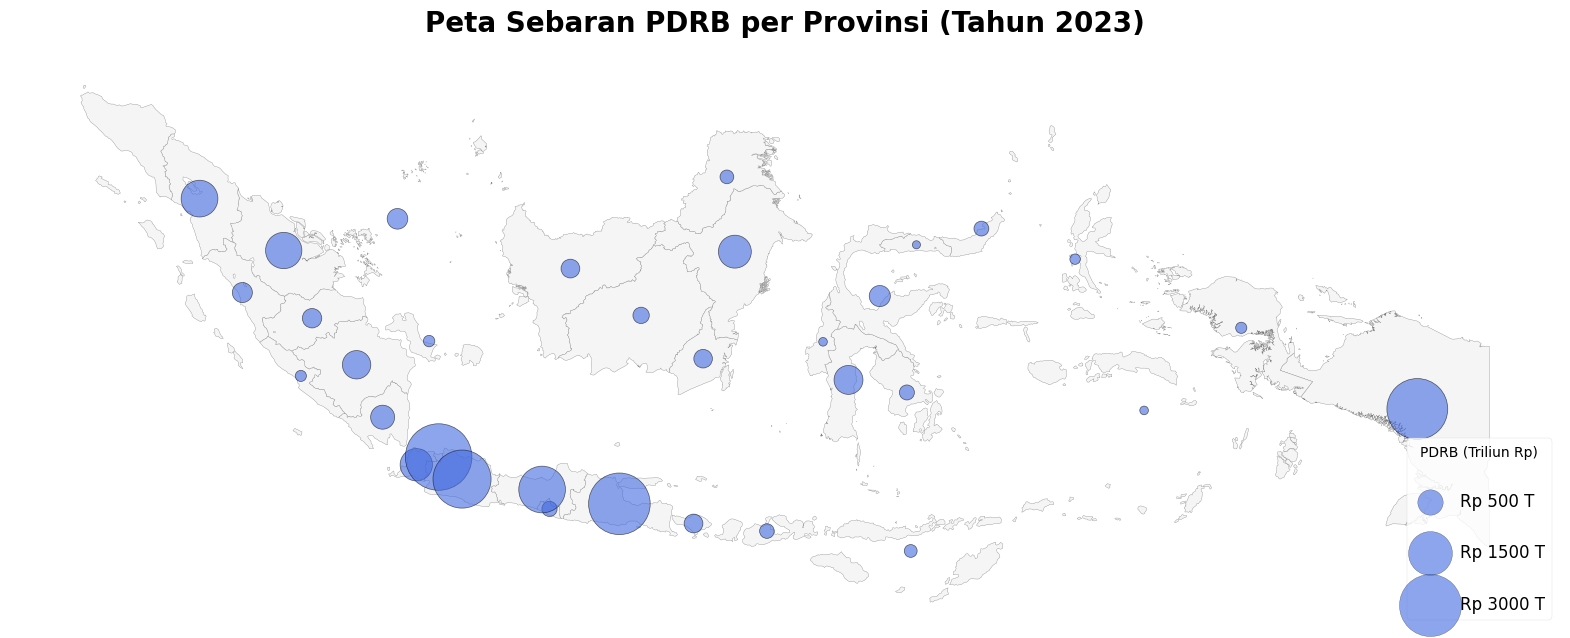

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

print("--- Memulai Proses Pembuatan Peta Bubble (GeoJSON Baru) ---")

# --- 1. MEMBACA DAN MENYIAPKAN DATA ANDA ---
try:
    df = pd.read_csv('final_results_full_panel.csv')
    print("Berhasil memuat file 'data.csv'.")
except FileNotFoundError:
    print("ERROR: File 'data.csv' tidak ditemukan.")
    exit()

latest_year = df['year'].max()
df_latest = df[df['year'] == latest_year].copy()
print(f"Data akan divisualisasikan untuk tahun terbaru: {latest_year}")


# --- 2. MENDAPATKAN DATA PETA (GeoJSON) ---
# PERUBAHAN 1: Menggunakan URL GeoJSON yang baru
geojson_url = "https://raw.githubusercontent.com/ans-4175/peta-indonesia-geojson/refs/heads/master/indonesia-prov.geojson"
try:
    gdf = gpd.read_file(geojson_url)
    geojson_available = True
    print("Berhasil mengunduh data peta GeoJSON dari URL baru.")
except Exception as e:
    print(f"Gagal mengunduh data peta GeoJSON: {e}")
    geojson_available = False


if geojson_available:
    # --- 3. MENYAMAKAN NAMA PROVINSI (LOGIKA OTOMATIS DIPERBARUI) ---
    # PERUBAHAN 2: Menambahkan 'Propinsi' sebagai prioritas deteksi
    province_col_name_in_gdf = ''
    if 'Propinsi' in gdf.columns:
        province_col_name_in_gdf = 'Propinsi'
    elif 'NAMA_PROV' in gdf.columns:
        province_col_name_in_gdf = 'NAMA_PROV'
    elif 'nama' in gdf.columns:
        province_col_name_in_gdf = 'nama'

    if not province_col_name_in_gdf:
        print("ERROR: Tidak dapat menemukan kolom nama provinsi ('Propinsi', 'NAMA_PROV', atau 'nama') di file GeoJSON.")
        exit()

    print(f"Kolom provinsi yang terdeteksi di GeoJSON: '{province_col_name_in_gdf}'")

    # Gunakan nama kolom yang sudah terdeteksi
    gdf['province_name_clean'] = gdf[province_col_name_in_gdf].str.upper()
    df_latest['province_name_clean'] = df_latest['province_name'].str.upper()

    # Menangani beberapa perbedaan nama yang umum
    name_mapping = {
        'KEPULAUAN BANGKA BELITUNG': 'BANGKA BELITUNG',
        'DAERAH ISTIMEWA YOGYAKARTA': 'DI YOGYAKARTA',
        'DAERAH KHUSUS IBUKOTA JAKARTA': 'DKI JAKARTA',
        'NUSATENGGARA BARAT': 'NUSA TENGGARA BARAT', # Contoh penyesuaian jika perlu
        'NUSATENGGARA TIMUR': 'NUSA TENGGARA TIMUR'
    }
    gdf['province_name_clean'] = gdf['province_name_clean'].replace(name_mapping)
    df_latest['province_name_clean'] = df_latest['province_name_clean'].replace(name_mapping)

    # --- 4. MENGGABUNGKAN DATA PETA DENGAN DATA ANDA ---
    merged_gdf = gdf.merge(df_latest, on='province_name_clean', how='left')

    bubble_variable = 'PDRB_resmi'
    merged_gdf[bubble_variable] = merged_gdf[bubble_variable].fillna(0)
    print(f"Variabel yang digunakan untuk ukuran bubble: '{bubble_variable}'")

    # --- 5. MEMBUAT PLOT PETA BUBBLE ---
    merged_gdf['centroid'] = merged_gdf.geometry.centroid

    fig, ax = plt.subplots(1, 1, figsize=(20, 12))

    merged_gdf.plot(ax=ax, color='whitesmoke', edgecolor='gray')

    scaling_factor = 1 / 1500

    plt.scatter(
        x=merged_gdf.centroid.x,
        y=merged_gdf.centroid.y,
        s=merged_gdf[bubble_variable] * scaling_factor,
        color='royalblue', # Ganti warna agar terlihat beda
        alpha=0.6,
        edgecolors='black',
        linewidth=0.5
    )

    for pdrb_value in [500000, 1500000, 3000000]:
        label_text = f'Rp {int(pdrb_value/1000)} T'
        ax.scatter([], [], c='royalblue', alpha=0.6, s=pdrb_value * scaling_factor,
                   edgecolors='black', label=label_text)

    ax.legend(scatterpoints=1, frameon=True, labelspacing=2,
              title='PDRB (Triliun Rp)', loc='lower right', fontsize='large')

    ax.set_title(f'Peta Sebaran PDRB per Provinsi (Tahun {latest_year})',
                 fontsize=20, weight='bold', pad=20)
    ax.set_axis_off()

    output_filename = 'peta_bubble_PDRB_final.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\n--- Proses Selesai ---")
    print(f"Peta berhasil disimpan sebagai '{output_filename}'")
    plt.show()

else:
    print("\nPeta tidak dapat dibuat karena data GeoJSON tidak tersedia.")

--- Memulai Proses Pembuatan Peta Choropleth ---
Berhasil memuat file 'data.csv'.
Data akan divisualisasikan untuk tahun terbaru: 2023
Berhasil mengunduh data peta GeoJSON.
Kolom provinsi yang terdeteksi di GeoJSON: 'Propinsi'
Data peta dan data CSV berhasil digabungkan.

--- REPLIKASI: Membuat Peta Choropleth ---

--- Proses Selesai ---
Peta berhasil disimpan sebagai 'peta_choropleth_PDRB_NTL.png'


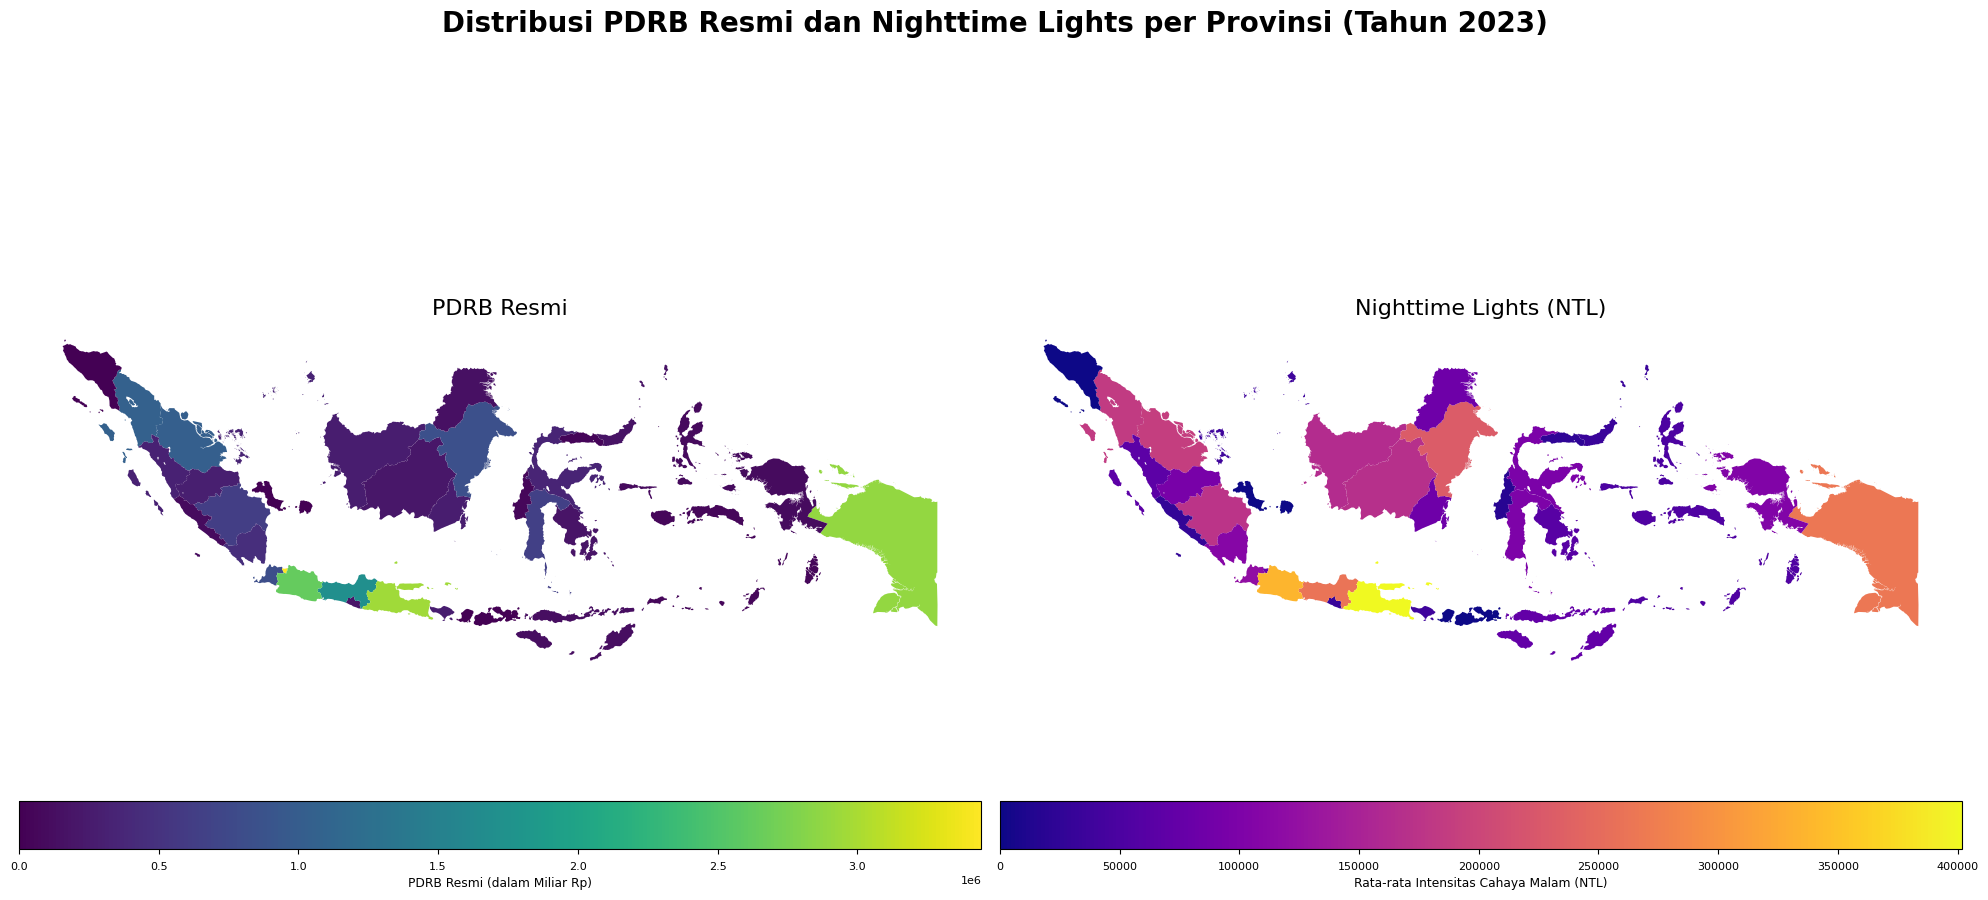

In [14]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

print("--- Memulai Proses Pembuatan Peta Choropleth ---")

# --- 1. MEMBACA DAN MENYIAPKAN DATA ANDA (Sama seperti sebelumnya) ---
try:
    df = pd.read_csv('final_results_full_panel.csv')
    print("Berhasil memuat file 'data.csv'.")
except FileNotFoundError:
    print("ERROR: File 'data.csv' tidak ditemukan.")
    exit()

latest_year = df['year'].max()
df_latest = df[df['year'] == latest_year].copy()
print(f"Data akan divisualisasikan untuk tahun terbaru: {latest_year}")


# --- 2. MENDAPATKAN DATA PETA (GeoJSON) (Sama seperti sebelumnya) ---
geojson_url = "https://raw.githubusercontent.com/ans-4175/peta-indonesia-geojson/refs/heads/master/indonesia-prov.geojson"
try:
    gdf = gpd.read_file(geojson_url)
    geojson_available = True
    print("Berhasil mengunduh data peta GeoJSON.")
except Exception as e:
    print(f"Gagal mengunduh data peta GeoJSON: {e}")
    geojson_available = False


if geojson_available:
    # --- 3. MENGGABUNGKAN DATA (Sama seperti sebelumnya) ---
    # Logika deteksi nama kolom provinsi secara otomatis
    province_col_name_in_gdf = ''
    if 'Propinsi' in gdf.columns:
        province_col_name_in_gdf = 'Propinsi'
    elif 'NAMA_PROV' in gdf.columns:
        province_col_name_in_gdf = 'NAMA_PROV'
    elif 'nama' in gdf.columns:
        province_col_name_in_gdf = 'nama'

    if not province_col_name_in_gdf:
        print("ERROR: Tidak dapat menemukan kolom nama provinsi di file GeoJSON.")
        exit()

    print(f"Kolom provinsi yang terdeteksi di GeoJSON: '{province_col_name_in_gdf}'")

    gdf['province_name_clean'] = gdf[province_col_name_in_gdf].str.upper()
    df_latest['province_name_clean'] = df_latest['province_name'].str.upper()

    # Gabungkan data
    merged_gdf = gdf.merge(df_latest, on='province_name_clean', how='left')

    # Isi nilai NaN (provinsi yang tidak ada di data Anda) dengan 0 agar bisa di-plot
    merged_gdf['PDRB_resmi'] = merged_gdf['PDRB_resmi'].fillna(0)
    merged_gdf['NTL_mean'] = merged_gdf['NTL_mean'].fillna(0)
    print("Data peta dan data CSV berhasil digabungkan.")

    # --- 4. MEMBUAT PLOT PETA CHOROPLETH (Bagian Baru) ---
    print("\n--- REPLIKASI: Membuat Peta Choropleth ---")

    # Membuat 2 subplot (1 baris, 2 kolom)
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    # Menambahkan judul utama untuk keseluruhan gambar
    fig.suptitle(f'Distribusi PDRB Resmi dan Nighttime Lights per Provinsi (Tahun {latest_year})',
                 fontsize=20, weight='bold')

    # Peta 1: PDRB Resmi
    merged_gdf.plot(
        column='PDRB_resmi',
        ax=axes[0],
        legend=True,
        cmap='viridis',  # Pilihan skema warna
        legend_kwds={
            'label': "PDRB Resmi (dalam Miliar Rp)",
            'orientation': "horizontal"
        }
    )
    axes[0].set_title('PDRB Resmi', fontsize=16)
    axes[0].set_axis_off()

    # Peta 2: Nighttime Lights (NTL)
    merged_gdf.plot(
        column='NTL_mean',
        ax=axes[1],
        legend=True,
        cmap='plasma', # Pilihan skema warna yang berbeda
        legend_kwds={
            'label': "Rata-rata Intensitas Cahaya Malam (NTL)",
            'orientation': "horizontal"
        }
    )
    axes[1].set_title('Nighttime Lights (NTL)', fontsize=16)
    axes[1].set_axis_off()

    # Merapikan layout agar judul tidak tumpang tindih dengan plot
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    # Simpan dan tampilkan gambar
    output_filename = 'peta_choropleth_PDRB_NTL.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\n--- Proses Selesai ---")
    print(f"Peta berhasil disimpan sebagai '{output_filename}'")
    plt.show()

else:
    print("\nPeta tidak dapat dibuat karena data GeoJSON tidak tersedia.")